In [1]:
# installing and importing required libraries

!pip install wordcloud

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
try:
    nltk.download('punkt_tab')
except:
    pass

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# For reproducibility
RANDOM_STATE = 42


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# 2) text preprocessing and plotting helpers

URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')

def basic_clean(s: str) -> str:

    if pd.isna(s):
        return ""
    s = str(s)
    s = s.lower()
    s = URL_PATTERN.sub(" ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def extract_first_sentence(s: str) -> str:
    if not isinstance(s, str) or not s.strip():
        return ""
    sents = sent_tokenize(s)
    return sents[0] if sents else ""

def clip_tokens(s: str, max_tokens: int = 80) -> str:

    tokens = s.split()
    if len(tokens) <= max_tokens:
        return s
    return " ".join(tokens[:max_tokens])

def plot_word_stats(text_series: pd.Series, title_prefix: str, top_n: int = 20):

    # join all text and split into tokens
    all_tokens = " ".join(text_series.astype(str)).split()
    counter = Counter(all_tokens)
    most_common = counter.most_common(top_n)

    words, counts = zip(*most_common)

    # Bar chart (like your first image)
    plt.figure(figsize=(12,6))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Word")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} – Top {top_n} Words (including stopwords)")
    plt.tight_layout()
    plt.show()

    # Word cloud (remove stopwords)
    eng_stopwords = set(stopwords.words("english"))
    filtered_tokens = [w for w in all_tokens if w.lower() not in eng_stopwords]
    text_for_wc = " ".join(filtered_tokens)

    wc = WordCloud(width=800, height=400, background_color="white").generate(text_for_wc)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{title_prefix} – Word Cloud (stopwords removed)")
    plt.show()


In [3]:
# Loading and normalizing LIAR dataset


liar_cols = [
    "id","label","statement","subject","speaker","speaker_job","state","party",
    "barely_true_count","false_count","half_true_count","mostly_true_count",
    "pants_on_fire_count","context"
]

liar_train = pd.read_csv("train.tsv", sep="\t", header=None, names=liar_cols)
liar_val   = pd.read_csv("valid.tsv", sep="\t", header=None, names=liar_cols)
liar_test  = pd.read_csv("test.tsv",  sep="\t", header=None, names=liar_cols)

liar_all = pd.concat([liar_train, liar_val, liar_test], ignore_index=True)

liar_label_map = {
    "true": 0,
    "mostly-true": 0,
    "half-true": 0,
    "false": 1,
    "barely-true": 1,
    "pants-fire": 1,
    "pants-on-fire": 1,
}

liar_all["label_str"] = liar_all["label"].astype(str).str.lower().str.strip()
liar_all["label_bin"] = liar_all["label_str"].map(liar_label_map)

unknown_liar = liar_all[liar_all["label_bin"].isna()]["label_str"].value_counts()
print("LIAR unknown labels (should be None or empty):\n",
      unknown_liar if not unknown_liar.empty else "None")

liar_all["label_bin"] = liar_all["label_bin"].fillna(1).astype(int)

liar_all["statement"] = liar_all["statement"].fillna("").astype(str)
liar_all["text_clean"] = liar_all["statement"].apply(basic_clean).apply(clip_tokens)

liar_norm = pd.DataFrame({
    "text": liar_all["text_clean"],
    "label": liar_all["label_bin"].astype(int),
    "source": "liar"
})

print("LIAR normalized shape:", liar_norm.shape, "label counts:\n",
      liar_norm["label"].value_counts())


LIAR unknown labels (should be None or empty):
 None
LIAR normalized shape: (12791, 3) label counts:
 label
0    7134
1    5657
Name: count, dtype: int64


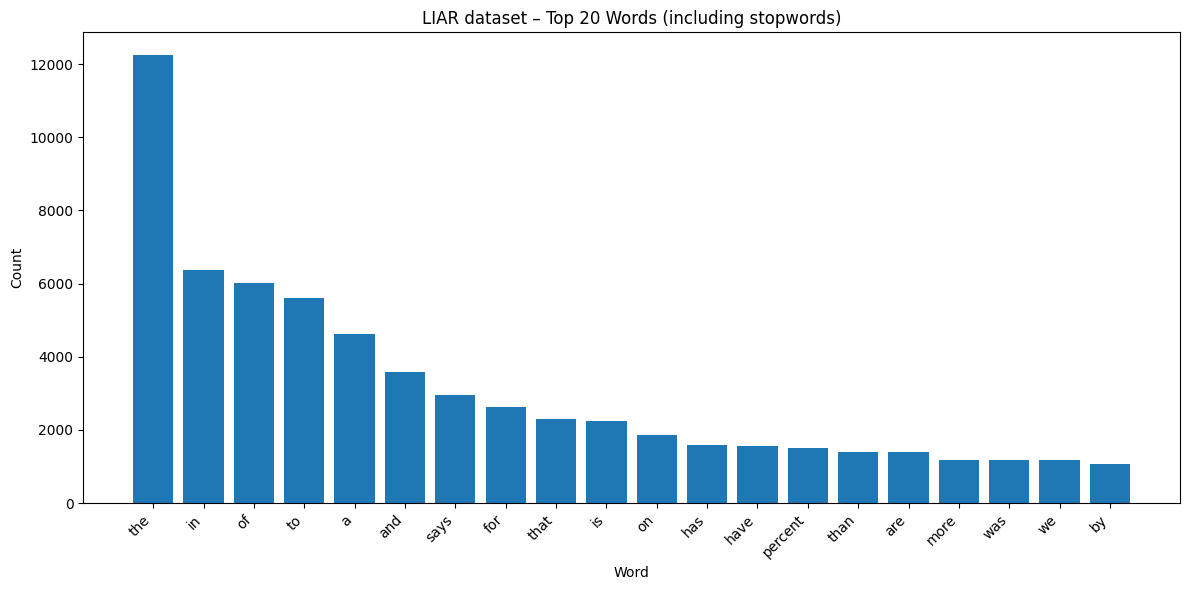

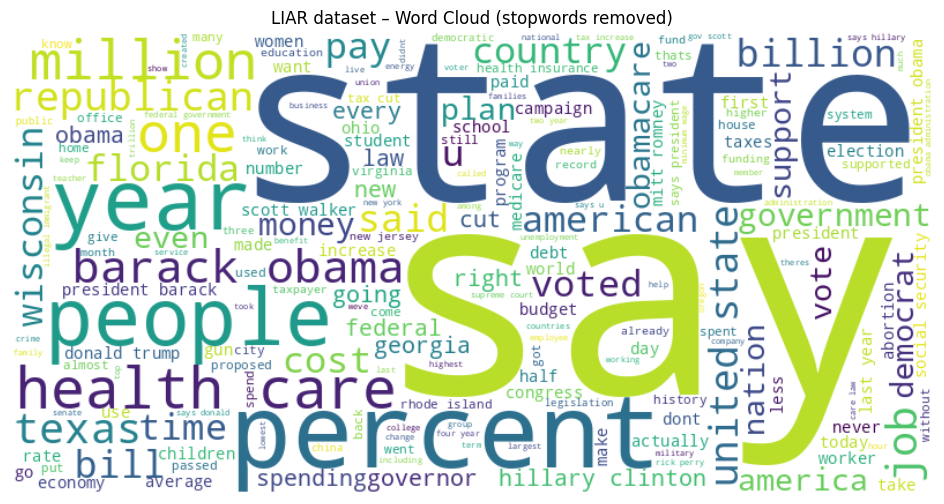

In [4]:
#LIAR WORD STATS


plot_word_stats(liar_norm["text"], "LIAR dataset")


In [5]:
# loading and normalizing ISOT dataset

iso_true = pd.read_csv("True.csv",  low_memory=False)
iso_fake = pd.read_csv("Fake.csv",  low_memory=False)

iso_true["label_bin"] = 0  # REAL
iso_fake["label_bin"] = 1  # FAKE

iso_true["title"] = iso_true["title"].fillna("").astype(str)
iso_true["text"]  = iso_true["text"].fillna("").astype(str)
iso_fake["title"] = iso_fake["title"].fillna("").astype(str)
iso_fake["text"]  = iso_fake["text"].fillna("").astype(str)

iso_all = pd.concat([iso_true, iso_fake], ignore_index=True)

iso_all["first_sentence"] = iso_all["text"].apply(extract_first_sentence)
iso_all["title_clean"]    = iso_all["title"].apply(basic_clean)
iso_all["first_clean"]    = iso_all["first_sentence"].apply(basic_clean)

iso_all["text_clean"] = (iso_all["title_clean"] + " " + iso_all["first_clean"]).str.strip()
iso_all["text_clean"] = iso_all["text_clean"].apply(clip_tokens)

iso_norm = pd.DataFrame({
    "text": iso_all["text_clean"],
    "label": iso_all["label_bin"].astype(int),
    "source": "isot"
})

print("ISOT normalized shape:", iso_norm.shape, "label counts:\n",
      iso_norm["label"].value_counts())


ISOT normalized shape: (44898, 3) label counts:
 label
1    23481
0    21417
Name: count, dtype: int64


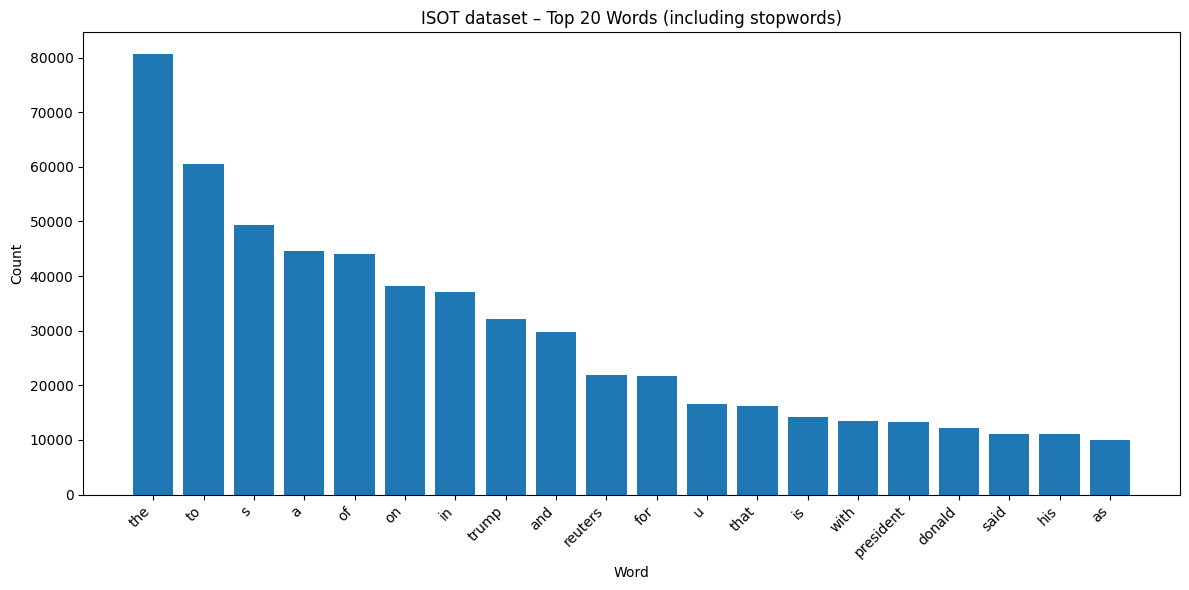

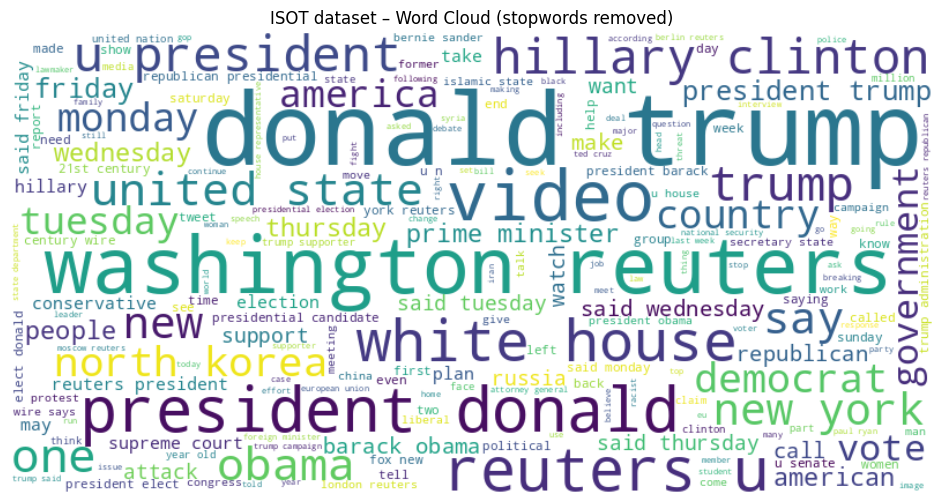

In [6]:
plot_word_stats(iso_norm["text"], "ISOT dataset")

In [7]:
# balancing and combining datasets

print("\nCombined shape BEFORE balancing:",
      pd.concat([liar_norm, iso_norm]).shape)

# Downsample ISOT to match LIAR size
desired_size = len(liar_norm)
iso_down = iso_norm.sample(n=desired_size, random_state=RANDOM_STATE)

print("Original ISOT:", iso_norm.shape)
print("Downsampled ISOT:", iso_down.shape)

combined = pd.concat([liar_norm, iso_down], ignore_index=True)
combined = combined.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("\nBalanced combined shape:", combined.shape)
print("Source distribution:\n", combined["source"].value_counts())
print("Label distribution:\n", combined["label"].value_counts())

combined.to_csv("merged_fake_news_dataset.csv", index=False)
print("\nSaved merged dataset to 'merged_fake_news_dataset.csv'")
from google.colab import files
files.download("merged_fake_news_dataset.csv")



Combined shape BEFORE balancing: (57689, 3)
Original ISOT: (44898, 3)
Downsampled ISOT: (12791, 3)

Balanced combined shape: (25582, 3)
Source distribution:
 source
isot    12791
liar    12791
Name: count, dtype: int64
Label distribution:
 label
0    13290
1    12292
Name: count, dtype: int64

Saved merged dataset to 'merged_fake_news_dataset.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# splitting data for training and testing

texts  = combined["text"].fillna("")
labels = combined["label"].astype(int).values

X_train_text, X_test_text, y_train, y_test, df_train, df_test = train_test_split(
    texts,
    labels,
    combined,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=labels
)

print("\nTrain size:", len(X_train_text), "Test size:", len(X_test_text))
print("y_train dist:", pd.Series(y_train).value_counts().to_dict())
print("y_test dist:",  pd.Series(y_test).value_counts().to_dict())



Train size: 20465 Test size: 5117
y_train dist: {0: 10632, 1: 9833}
y_test dist: {0: 2658, 1: 2459}


In [9]:
# TF-IDF vectorization

tf_vec = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    token_pattern=r'(?u)\b[a-zA-Z]{3,}\b'
)

X_train = tf_vec.fit_transform(X_train_text)
X_test  = tf_vec.transform(X_test_text)

print("\nTF-IDF train shape:", X_train.shape)
print("TF-IDF test  shape:", X_test.shape)



TF-IDF train shape: (20465, 20717)
TF-IDF test  shape: (5117, 20717)


In [10]:
# Training 3 ML algorithms

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        solver="saga",
        n_jobs=-1
    ),
    "LinearSVC": LinearSVC(
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "MultinomialNB": MultinomialNB(),
}

for name, clf in models.items():
    print(f"\nTrained {name}")
    clf.fit(X_train, y_train)

print("\nFinished training all models on balanced combined dataset.")



Trained LogisticRegression

Trained LinearSVC

Trained MultinomialNB

Finished training all models on balanced combined dataset.



EVALUATION ON HELD-OUT TEST SET

MODEL: LogisticRegression
Accuracy: 0.7925

Classification Report (REAL=0, FAKE=1):
              precision    recall  f1-score   support

        REAL     0.8032    0.7953    0.7992      2658
        FAKE     0.7811    0.7893    0.7852      2459

    accuracy                         0.7925      5117
   macro avg     0.7921    0.7923    0.7922      5117
weighted avg     0.7926    0.7925    0.7925      5117

Confusion Matrix (rows=true, cols=pred):
[[2114  544]
 [ 518 1941]]



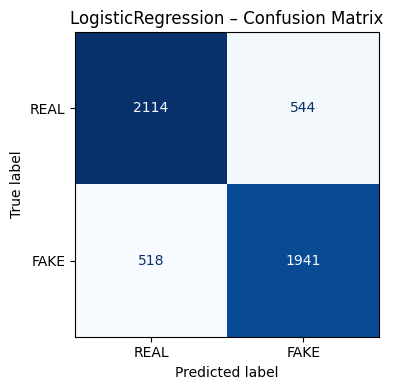

MODEL: LinearSVC
Accuracy: 0.7811

Classification Report (REAL=0, FAKE=1):
              precision    recall  f1-score   support

        REAL     0.7842    0.7983    0.7912      2658
        FAKE     0.7777    0.7625    0.7700      2459

    accuracy                         0.7811      5117
   macro avg     0.7809    0.7804    0.7806      5117
weighted avg     0.7811    0.7811    0.7810      5117

Confusion Matrix (rows=true, cols=pred):
[[2122  536]
 [ 584 1875]]



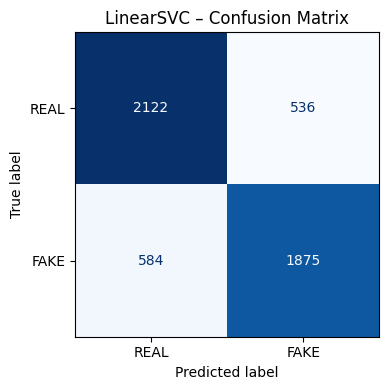

MODEL: MultinomialNB
Accuracy: 0.7790

Classification Report (REAL=0, FAKE=1):
              precision    recall  f1-score   support

        REAL     0.7705    0.8183    0.7937      2658
        FAKE     0.7895    0.7365    0.7620      2459

    accuracy                         0.7790      5117
   macro avg     0.7800    0.7774    0.7778      5117
weighted avg     0.7796    0.7790    0.7785      5117

Confusion Matrix (rows=true, cols=pred):
[[2175  483]
 [ 648 1811]]



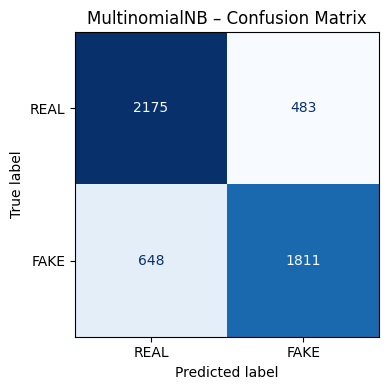

In [11]:
# evaluation and confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

print("\nEVALUATION ON HELD-OUT TEST SET\n")

for name, clf in models.items():

    print(f"MODEL: {name}")


    # Predictions
    preds = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, preds)
    print(f"Accuracy: {acc:.4f}\n")

    # Text report
    print("Classification Report (REAL=0, FAKE=1):")
    print(classification_report(
        y_test,
        preds,
        target_names=["REAL", "FAKE"],
        digits=4
    ))

    # Confusion matrix values
    cm = confusion_matrix(y_test, preds, labels=[0, 1])
    print("Confusion Matrix (rows=true, cols=pred):")
    print(cm)
    print()  # blank line

    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["REAL", "FAKE"])
    disp.plot(ax=ax, values_format='d', cmap="Blues", colorbar=False)
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [12]:
#authenticity function


#"LogisticRegression", "LinearSVC", "MultinomialNB"
best_model_name = "LogisticRegression"
best_model = models[best_model_name]

print(f"Using {best_model_name} as main model for authenticity scoring.")

def predict_authenticity(text: str):
    """
    Input:
        text (str): raw news/claim/article text

    Output:
        pred_label (int): 0 = REAL, 1 = FAKE
        auth_score (float): estimated probability that the text is REAL, in %
    """
    if not isinstance(text, str):
        text = str(text)

    # Same preprocessing as training
    first_sent = extract_first_sentence(text)
    feat = (basic_clean(text) + " " + basic_clean(first_sent)).strip()
    feat = clip_tokens(feat, max_tokens=80)

    # Vectorize
    X_vec = tf_vec.transform([feat])

    # LogisticRegression: get true probabilities
    proba = best_model.predict_proba(X_vec)[0]  # [P(REAL), P(FAKE)] in some order
    class_order = list(best_model.classes_)     # e.g. [0, 1]
    idx_real = class_order.index(0)             # index of REAL class
    real_score = float(proba[idx_real])         # probability that label = 0 (REAL)

    pred_label = int(best_model.predict(X_vec)[0])
    auth_score = round(real_score * 100.0, 2)   # convert to percentage

    return pred_label, auth_score


Using LogisticRegression as main model for authenticity scoring.


In [13]:

#CALCULATE AUTHENTICITY

# Take first 10 rows from the merged (balanced) dataset
preview_df = combined.head(10).copy()

pred_labels = []
auth_scores = []

for txt in preview_df["text"]:
    pred, score = predict_authenticity(txt)
    pred_labels.append(pred)
    auth_scores.append(score)

# Map numeric labels to readable strings
label_map = {0: "REAL", 1: "FAKE"}

preview_df["true_label_str"] = preview_df["label"].map(label_map)
preview_df["pred_label"] = pd.Series(pred_labels).map(label_map)
preview_df["authenticity_real_%"] = auth_scores

cols_to_show = [
    "source",
    "text",
    "true_label_str",
    "pred_label",
    "authenticity_real_%"
]

print("First 10 samples from the merged dataset with authenticity scores:\n")
display(preview_df[cols_to_show])


First 10 samples from the merged dataset with authenticity scores:



,source,text,true_label_str,pred_label,authenticity_real_%
0,isot,flashback army of women join social media craz...,FAKE,FAKE,5.58
1,liar,democrats have lost more than 900 state legisl...,REAL,REAL,69.61
2,isot,democrat thugs vandalize republican offices ac...,FAKE,FAKE,43.86
3,liar,says a drug test can be performed for just 4 or 5,REAL,FAKE,33.98
4,isot,democrat senator jon tester will vote against ...,REAL,REAL,97.22
5,liar,frankly hillary clinton doesnt do very well wi...,FAKE,FAKE,20.76
6,isot,factbox raqqa battle for islamic state s syria...,REAL,REAL,96.37
7,liar,six out of 10 of the highest unemployment rate...,REAL,REAL,66.69
8,isot,trump to visit paris for bastille day at macro...,REAL,REAL,99.06
9,liar,congress secured special obamacare rules to pr...,REAL,FAKE,37.79


In [14]:
!pip install gradio


In [15]:
import gradio as gr
import pandas as pd

label_map = {0: "REAL", 1: "FAKE"}

# Function that Gradio will call
def analyze_text(input_text):
    if not input_text.strip():
        return "Please enter some text", "", "", ""

    pred_label, score = predict_authenticity(input_text)
    pred_str = label_map[pred_label]

    # For debugging, show the cleaned text too
    first_sent = extract_first_sentence(input_text)
    feat = (basic_clean(input_text) + " " + basic_clean(first_sent)).strip()
    feat = clip_tokens(feat, max_tokens=80)

    return pred_str, f"{score}%", feat, input_text

# UI with Gradio Blocks
with gr.Blocks() as app:
    gr.Markdown("<h1 style='text-align: center;'>📰 Fake News Detector (with Authenticity Score)</h1>")

    text_input = gr.Textbox(
        label="Enter News Text / Claim:",
        placeholder="Paste a headline, article, or claim here...",
        lines=8
    )

    analyze_btn = gr.Button("Analyze")

    pred_output = gr.Textbox(label="Prediction (REAL or FAKE)")
    auth_output = gr.Textbox(label="Authenticity (REAL %)")


    analyze_btn.click(
        fn=analyze_text,
        inputs=text_input,
        outputs=[pred_output, auth_output]
    )

app.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://30b19299ec746a2017.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://30b19299ec746a2017.gradio.live
